In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import xml.etree.ElementTree as ET
from pathlib import Path
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset,random_split
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models 
import torch.nn as nn

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/dataset/Image_Road Sign Detection/all_data.csv",index_col=False)
data.head()

,Unnamed: 0,filename,class
0,0,/content/drive/MyDrive/dataset/Image_Road Sign...,trafficlight
1,1,/content/drive/MyDrive/dataset/Image_Road Sign...,trafficlight
2,2,/content/drive/MyDrive/dataset/Image_Road Sign...,trafficlight
3,3,/content/drive/MyDrive/dataset/Image_Road Sign...,speedlimit
4,4,/content/drive/MyDrive/dataset/Image_Road Sign...,speedlimit


In [ ]:
mapping_classes = {i:j for j,i in enumerate(np.unique(data["class"]))}
data["class"] = data["class"].map(mapping_classes)


image_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((256,256)),
                                      transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                            (0.2470, 0.2435, 0.2616))])


class Image_Dataset(Dataset):
  def __init__(self,X,Y):
    self.image = X
    self.label = Y

  def __getitem__(self,index):
    images = self.image[index]
    labels = self.label[index]
    image = Image.open(images)
    img=image.convert("RGB")
    array_img = np.array(img)
    transform_images = image_transform(array_img)
    # image_array = torch
    # image=np.transpose(image,(2,0,1)).astype(np.float32)
    y = torch.tensor(labels,dtype=torch.long)
    return (transform_images,y)

  def __len__(self):
    return len(self.image)

In [ ]:
data["filename"][0],data["class"][0]

('/content/drive/MyDrive/dataset/Image_Road Sign Detection/images/road10.png',
 3)

In [ ]:
dataset = Image_Dataset(data["filename"].values,data["class"].values)

In [ ]:
for i,j in dataset:
  print(i,j)
  break

tensor([[[-0.2072, -0.1958, -0.1799,  ..., -0.1417, -0.1640, -0.1755],
         [-0.2065, -0.1949, -0.1799,  ..., -0.1413, -0.1640, -0.1755],
         [-0.1953, -0.1821, -0.1789,  ..., -0.1353, -0.1640, -0.1755],
         ...,
         [-1.3072, -1.3206, -1.3447,  ..., -0.8001, -0.8147, -0.8108],
         [-1.3072, -1.3080, -1.3426,  ..., -0.7903, -0.8025, -0.8257],
         [-1.3028, -1.3047, -1.3487,  ..., -0.7897, -0.8016, -0.8264]],

        [[-0.1883, -0.1766, -0.1608,  ..., -0.3606, -0.3702, -0.3818],
         [-0.1769, -0.1633, -0.1608,  ..., -0.3602, -0.3702, -0.3818],
         [-0.1752, -0.1631, -0.1598,  ..., -0.3541, -0.3702, -0.3818],
         ...,
         [-1.0949, -1.0949, -1.1176,  ..., -0.6440, -0.6584, -0.6571],
         [-1.0949, -1.0949, -1.1147,  ..., -0.6440, -0.6601, -0.6709],
         [-1.0905, -1.0792, -1.1210,  ..., -0.6440, -0.6601, -0.6717]],

        [[ 1.2497,  1.2605,  1.2752,  ...,  0.5945,  0.5859,  0.5749],
         [ 1.2605,  1.2730,  1.2758,  ...,  0

In [ ]:
train_size = 0.8
train_data = int(len(dataset) * train_size)
test_data = int(len(dataset) - train_data)

train_dataset,test_dataset = random_split(dataset,[train_data,test_data])

train_loader = DataLoader(train_dataset, batch_size = 32,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32,shuffle = False)  

In [ ]:
# class ResBlock(nn.Module):
#     def __init__(self, n_chans):
#         super(ResBlock, self).__init__()
#         self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
#                               padding=1, bias=False)  # <1>
#         self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
#         torch.nn.init.kaiming_normal_(self.conv.weight,
#                                       nonlinearity='relu')  # <2>
#         torch.nn.init.constant_(self.batch_norm.weight, 0.5)
#         torch.nn.init.zeros_(self.batch_norm.bias)

#     def forward(self, x):
#         out = self.conv(x)
#         out = self.batch_norm(out)
#         out = torch.relu(out)
#         return out + x


        

In [ ]:
# class NetResDeep(nn.Module):
#     def __init__(self, n_chans1=32, n_blocks=5):
#         super().__init__()
#         self.n_chans1 = n_chans1
#         self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
#         self.resblocks = nn.Sequential(
#             *(n_blocks * [ResBlock(n_chans=n_chans1)]))
#         self.fc1 = nn.Linear(n_chans1, 32)
#         self.fc2 = nn.Linear(32, len(mapping_classes))
        
#     def forward(self, x):
#         out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
#         out = self.resblocks(out)
#         out = F.max_pool2d(out, 2)
#         bs,_,_,_=out.shape
#         out = F.adaptive_avg_pool2d(out,1).reshape(bs,-1)
#         out = torch.relu(self.fc1(out))
#         out = self.fc2(out)
#         return out

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.fc1 = nn.Linear(128, 256)
    self.fc2 = nn.Linear(256,len(mapping_classes))
    self.dropout = nn.Dropout(p=0.3)

  def forward(self,x):
    out = F.max_pool2d(torch.relu(self.conv1(x)),2)
    out = self.batchnorm1(out)
    out = F.max_pool2d(torch.relu(self.conv2(out)),2)
    out = self.batchnorm2(out)
    out = F.max_pool2d(torch.relu(self.conv3(out)),2)
    out = self.batchnorm3(out)
    bs,_,_,_=out.shape
    out = F.adaptive_avg_pool2d(out,1).reshape(bs,-1)
    out = self.dropout(out)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return nn.Sigmoid()(out)

In [ ]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
model=models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# model.fc = nn.Sequential(nn.Linear(2048, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 10),
#                                  nn.LogSoftmax(dim=1))

model.fc=nn.Sequential(nn.Linear(2048,512),
                       nn.ReLU(),
                       nn.Dropout(0.2),
                       nn.Linear(512,len(mapping_classes)),
                       nn.LogSoftmax(dim=1))

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# model=NetResDeep()
# model = model

In [ ]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.fc.parameters() , lr=0.001)

In [ ]:
dirs="/content/drive/MyDrive/dataset/Image_Road Sign Detection/"

In [ ]:
model.train()

for epoch in range(20):
  loss_train = 0.0
  for image,label in train_loader:
    image = image.to(device)
    optimizer.zero_grad()
    label = torch.LongTensor(label)
    # label = label.to(device)
    output = model(image)
    loss = criterion(output , label)
    loss.backward()
    optimizer.step()

    loss_train += loss.item()
    torch.save(model.state_dict(),dirs+"images_data2.pt")
  print(f"Epoch : {epoch+1}, loss : {loss_train / len(train_loader)}")

Epoch : 1, loss : 0.8197948466176572
Epoch : 2, loss : 0.5444328746070033
Epoch : 3, loss : 0.3950258318496787
Epoch : 4, loss : 0.3312816904938739


In [ ]:
img,_ = next(iter(train_loader))


NameError: ignored

In [ ]:
pred_data,_ = dataset[4]
pred_data,_

(tensor([[[-0.8944, -0.8941, -0.8654,  ..., -0.8785, -0.8944, -0.8944],
          [-0.8931, -0.8798, -0.8552,  ..., -0.8785, -0.8944, -0.8944],
          [-0.8723, -0.8609, -0.8386,  ..., -0.8785, -0.8944, -0.8944],
          ...,
          [-0.7351, -0.7205, -0.7032,  ..., -0.7039, -0.7039, -0.7039],
          [-0.7505, -0.7371, -0.7127,  ..., -0.7039, -0.7039, -0.7039],
          [-0.7515, -0.7381, -0.7133,  ..., -0.7039, -0.7039, -0.7039]],
 
         [[-0.4024, -0.3888, -0.3635,  ..., -0.3380, -0.3541, -0.3541],
          [-0.4011, -0.3876, -0.3555,  ..., -0.3380, -0.3541, -0.3541],
          [-0.3800, -0.3685, -0.3297,  ..., -0.3380, -0.3541, -0.3541],
          ...,
          [-0.1281, -0.1133, -0.0899,  ..., -0.0803, -0.0803, -0.0803],
          [-0.1437, -0.1301, -0.1049,  ..., -0.0803, -0.0803, -0.0803],
          [-0.1447, -0.1311, -0.1060,  ..., -0.0803, -0.0803, -0.0803]],
 
         [[ 0.4510,  0.4887,  0.5168,  ...,  0.5856,  0.5706,  0.5706],
          [ 0.4676,  0.4921,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


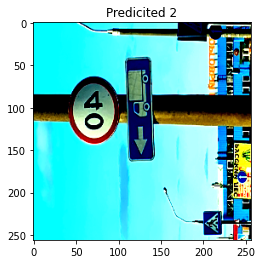

In [ ]:
img=Image.open("/content/drive/MyDrive/dataset/Image_Road Sign Detection/images/road785.png").convert("RGB")
# inp = pred_data.unsqueeze(0)

t=transforms.ToTensor()
t1=transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize((256,256)),
                                        transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                              (0.2470, 0.2435, 0.2616))])
inp=t1(img).unsqueeze(0)
model.eval()
predicted = model(inp).detach().numpy()
  # output = np.argmax(predicted)
  # output


inp2 = inp.squeeze(0)
plt.imshow(inp2.permute(2,1,0))
plt.title(f"Predicited {predicted.argmax()}",)
plt.show()

In [ ]:
predicted

array([[0.501167  , 0.50869286, 0.51234037, 0.49903044]], dtype=float32)

In [ ]:
predicted_class = np.argmax(predicted)
predicted_class

2

In [ ]:
inp.permute(2,1,0,3).shape

torch.Size([256, 3, 1, 256])

In [ ]:
|data.head()

,Unnamed: 0,filename,class
0,0,/content/drive/MyDrive/dataset/Image_Road Sign...,3
1,1,/content/drive/MyDrive/dataset/Image_Road Sign...,3
2,2,/content/drive/MyDrive/dataset/Image_Road Sign...,3
3,3,/content/drive/MyDrive/dataset/Image_Road Sign...,1
4,4,/content/drive/MyDrive/dataset/Image_Road Sign...,1


In [ ]:
data["filename"][170],data["class"][170]

('/content/drive/MyDrive/dataset/Image_Road Sign Detection/images/road785.png',
 1)

In [ ]:
def fit(model,loader):
  model.train()
  train_running_loss = 0
  train_running_correct = 0
  for epoch,data in enumerate(loader):
    
    image,label = data[0],data[1]
    optimizer.zero_grad()
    output = model(image)

    loss = criterion(output, label)

    train_running_loss += loss.item()
    _,pred = torch.max(output.data,1)
    train_running_correct += (pred == label).sum().item()
    loss.backward()
    optimizer.step()

  train_loss = train_running_loss / len(loader.dataset)
  train_accuracy = 100*train_running_correct / len(loader.dataset)

  print(f"Train loss: {train_loss:.4f} Train Acc: {train_accuracy:.2f}")

  return train_loss,train_accuracy


In [ ]:
def validate(model,loader):
  print("Validate.. ")
  model.eval()

  val_running_loss = 0.0
  val_running_correct = 0

  with torch.no_grad():
    for epoch,data in enumerate(loader):

      image,label = data[0],data[1]

      output = model(image)
      loss = criterion(output,label)

      val_running_loss += loss.item()
      _,pred = torch.max(output.data,1)
      val_running_correct  += (pred == label).sum().item()

    val_loss = val_running_loss / len(loader.dataset)
    val_accuracy = 100*val_running_correct / len(loader.dataset)

    print(f"Val Train: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}")
    return val_loss,val_accuracy


In [ ]:
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]

for epoch in range(20):
  print("Epoch {}".format(epoch+1))
  train_epoch_loss,train_epoch_accuracy = fit(model,train_loader)
  val_epoch_loss,val_epoch_accuracy = validate(model,test_loader)

  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)

  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

  torch.save(model.state_dict(),dirs+"images_data3.pt")


Epoch 1
Train loss: 0.0328 Train Acc: 74.19
Validate.. 
Val Train: 0.0319, Val Acc: 80.34
Epoch 2
Train loss: 0.0326 Train Acc: 75.18
Validate.. 
Val Train: 0.0319, Val Acc: 81.46
Epoch 3
Train loss: 0.0325 Train Acc: 75.46
Validate.. 
Val Train: 0.0317, Val Acc: 80.90
Epoch 4
Train loss: 0.0324 Train Acc: 75.46
Validate.. 
Val Train: 0.0318, Val Acc: 80.90
Epoch 5
Train loss: 0.0323 Train Acc: 75.18
Validate.. 
Val Train: 0.0317, Val Acc: 80.34
Epoch 6
Train loss: 0.0323 Train Acc: 75.32
Validate.. 
Val Train: 0.0316, Val Acc: 80.34
Epoch 7
Train loss: 0.0322 Train Acc: 75.04
Validate.. 
Val Train: 0.0316, Val Acc: 80.34
Epoch 8
Train loss: 0.0326 Train Acc: 75.46
Validate.. 
Val Train: 0.0315, Val Acc: 80.90
Epoch 9
Train loss: 0.0324 Train Acc: 75.74
Validate.. 
Val Train: 0.0315, Val Acc: 80.34
Epoch 10
Train loss: 0.0323 Train Acc: 75.46
Validate.. 
Val Train: 0.0315, Val Acc: 80.34
Epoch 11
Train loss: 0.0323 Train Acc: 75.32
Validate.. 
Val Train: 0.0313, Val Acc: 80.34
Epoch 12

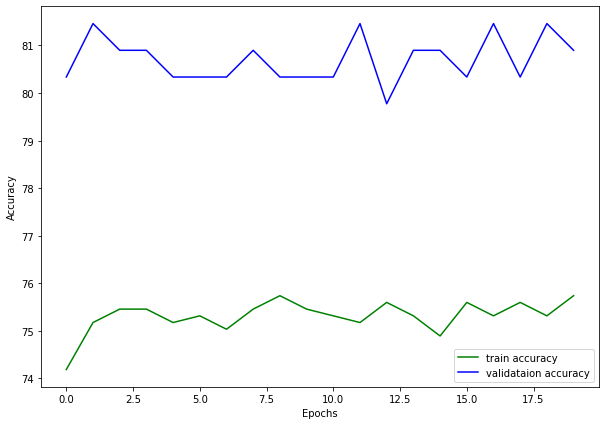

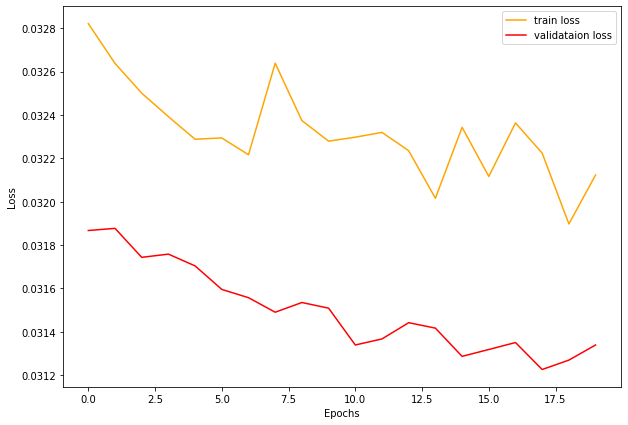

TRAINING COMPLETE


In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig(Dir2+'accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(Dir2+'loss.png')
plt.show()
    
# serialize the model to disk
# print('Saving model...')
# torch.save(model.state_dict(), args['model'])
 
print('TRAINING COMPLETE')

In [ ]:
dataset[0]

(tensor([[[-0.2072, -0.1958, -0.1799,  ..., -0.1417, -0.1640, -0.1755],
          [-0.2065, -0.1949, -0.1799,  ..., -0.1413, -0.1640, -0.1755],
          [-0.1953, -0.1821, -0.1789,  ..., -0.1353, -0.1640, -0.1755],
          ...,
          [-1.3072, -1.3206, -1.3447,  ..., -0.8001, -0.8147, -0.8108],
          [-1.3072, -1.3080, -1.3426,  ..., -0.7903, -0.8025, -0.8257],
          [-1.3028, -1.3047, -1.3487,  ..., -0.7897, -0.8016, -0.8264]],
 
         [[-0.1883, -0.1766, -0.1608,  ..., -0.3606, -0.3702, -0.3818],
          [-0.1769, -0.1633, -0.1608,  ..., -0.3602, -0.3702, -0.3818],
          [-0.1752, -0.1631, -0.1598,  ..., -0.3541, -0.3702, -0.3818],
          ...,
          [-1.0949, -1.0949, -1.1176,  ..., -0.6440, -0.6584, -0.6571],
          [-1.0949, -1.0949, -1.1147,  ..., -0.6440, -0.6601, -0.6709],
          [-1.0905, -1.0792, -1.1210,  ..., -0.6440, -0.6601, -0.6717]],
 
         [[ 1.2497,  1.2605,  1.2752,  ...,  0.5945,  0.5859,  0.5749],
          [ 1.2605,  1.2730,

In [ ]:
pred_img,_=dataset[200]
_

tensor(2)

In [ ]:
pred_img=pred_img.unsqueeze(0)

In [ ]:
pred_img.shape

torch.Size([1, 3, 256, 256])

In [ ]:
img=Image.open("/content/drive/MyDrive/dataset/Image_Road Sign Detection/images/road10.png").convert("RGB")

t=transforms.ToTensor()
inp=t(img).unsqueeze(0)


torch.Size([1, 3, 267, 400])

In [ ]:
tensor.shape

(267, 400, 3)

In [ ]:
predicted = model(inp).detach().numpy()

In [ ]:
predicted

array([[0.01186718, 0.9677482 , 0.01088286, 0.00950166]], dtype=float32)

In [ ]:
output=torch.argmax(torch.tensor(predicted))
output

tensor(1)

In [ ]:
model = model.load_state_dict(torch.load(dirs+"images_data2.pt"))


In [ ]:
model

<All keys matched successfully>

In [ ]:
model

<All keys matched successfully>

In [ ]:
predicted2 = model(inp).detach().numpy()

In [ ]:
predicted2

array([[0.04802458, 0.84308714, 0.06951857, 0.03936973]], dtype=float32)

In [ ]:
output=torch.argmax(torch.tensor(predicted))
output

tensor(1)